Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


C:\Users\server4\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 424ms/step - accuracy: 0.9651 - loss: 0.0904 - val_accuracy: 0.9990 - val_loss: 0.0045
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 95s 379ms/step - accuracy: 0.9938 - loss: 0.0169 - val_accuracy: 0.9665 - val_loss: 0.0974
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 384ms/step - accuracy: 0.9947 - loss: 0.0122 - val_accuracy: 0.9940 - val_loss: 0.0172
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 361ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9915 - val_loss: 0.0193
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 383ms/step - accuracy: 0.9945 - loss: 0.0134 - val_accuracy: 0.9735 - val_loss: 0.0789
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 377ms/step - accuracy: 0.9964 - loss: 0.0101 - val_accuracy: 0.9965 - val_loss: 0.0103


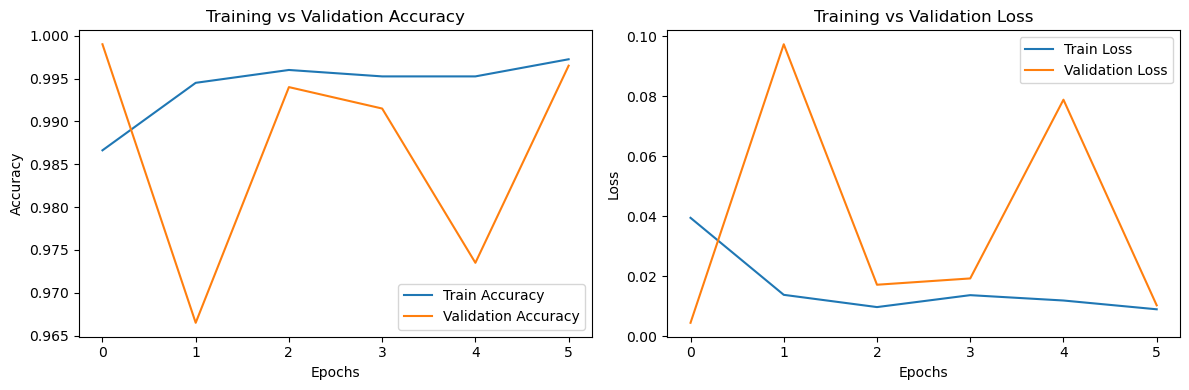

Final Training Accuracy: 0.9973
Final Validation Accuracy: 0.9965
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step


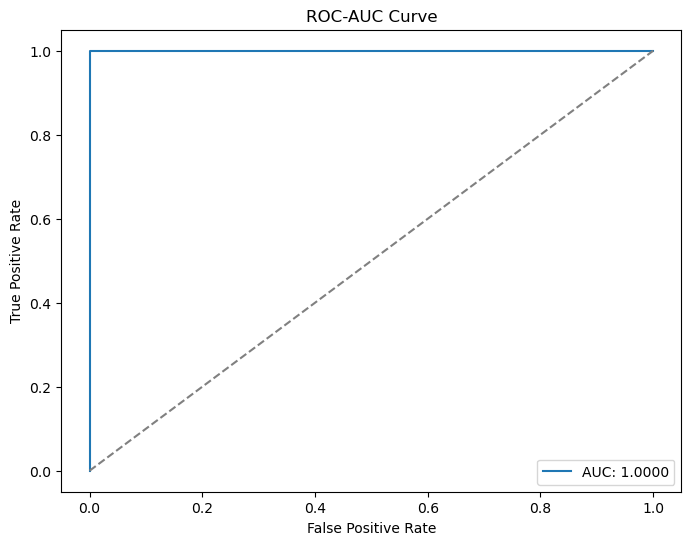

Classification Report:
              precision    recall  f1-score   support

AI-Generated       1.00      1.00      1.00      1000
        Real       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



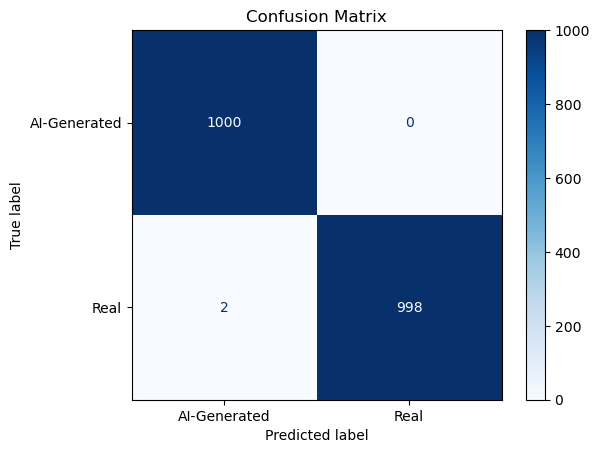

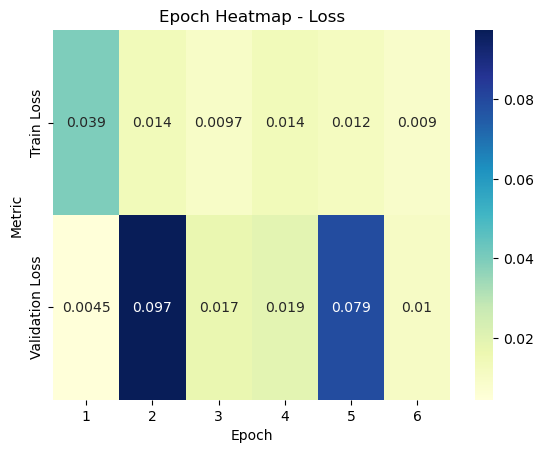

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Paths to datasets
train_dir = "C:/Users/server4/Desktop/split_data/train"
test_dir = "C:/Users/server4/Desktop/split_data/test"

# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data loading
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
)

# MobileNetV2 model setup
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the pre-trained layers

# Add custom layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")  # For binary classification
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint = ModelCheckpoint("mobilenetv2_best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    callbacks=[checkpoint, early_stopping]
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Extract final accuracy and loss
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Predict on test data
y_true = test_data.classes
y_pred_probs = model.predict(test_data, verbose=1)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
auc_score = roc_auc_score(y_true, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC: {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=["AI-Generated", "Real"])
print(f"Classification Report:\n{report}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-Generated", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Epoch heatmap (losses)
epoch_data = np.array([history.history["loss"], history.history["val_loss"]])
sns.heatmap(epoch_data, annot=True, cmap="YlGnBu", xticklabels=range(1, len(history.history["loss"]) + 1),
            yticklabels=["Train Loss", "Validation Loss"])
plt.title("Epoch Heatmap - Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.show()


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


C:\Users\91879\Downloads\DBMS-MINI-Project-master\New folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4063s 16s/step - accuracy: 0.4973 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 28323s 114s/step - accuracy: 0.4915 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 205s 820ms/step - accuracy: 0.4973 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 884ms/step - accuracy: 0.4981 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 238s 953ms/step - accuracy: 0.4927 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 947ms/step - accuracy: 0.4940 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931


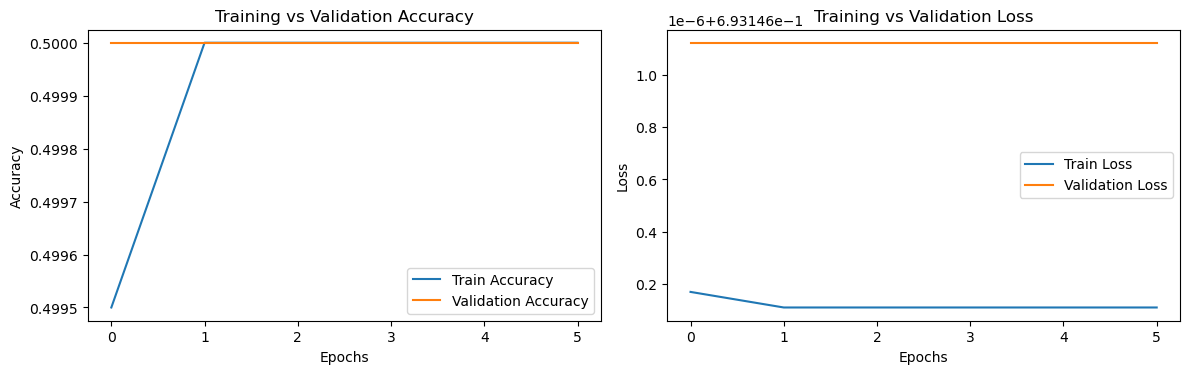

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step


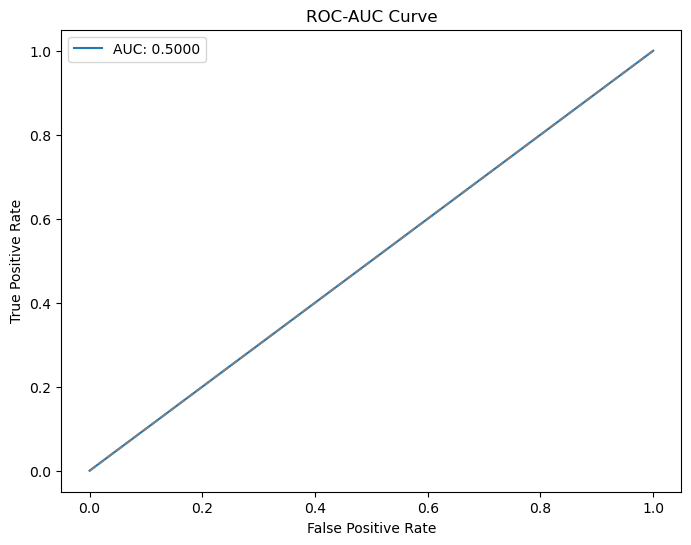

C:\Users\91879\Downloads\DBMS-MINI-Project-master\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91879\Downloads\DBMS-MINI-Project-master\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91879\Downloads\DBMS-MINI-Project-master\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification Report:
              precision    recall  f1-score   support

AI-Generated       0.50      1.00      0.67      1000
        Real       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



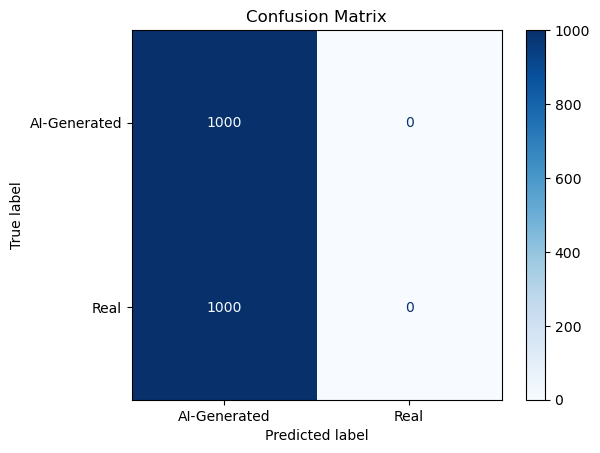

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# SqueezeNet Architecture (Custom Implementation)
def create_squeezenet(input_shape=(224, 224, 3), num_classes=1):
    def fire_module(x, squeeze, expand):
        x = Conv2D(squeeze, (1, 1), activation='relu')(x)
        x1 = Conv2D(expand, (1, 1), activation='relu')(x)
        x2 = Conv2D(expand, (3, 3), padding='same', activation='relu')(x)
        return tf.keras.layers.concatenate([x1, x2])

    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, squeeze=16, expand=64)
    x = fire_module(x, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, squeeze=32, expand=128)
    x = fire_module(x, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, squeeze=48, expand=192)
    x = fire_module(x, squeeze=48, expand=192)
    x = fire_module(x, squeeze=64, expand=256)
    x = fire_module(x, squeeze=64, expand=256)

    x = Dropout(0.5)(x)
    x = Conv2D(num_classes, (1, 1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model


# Paths to datasets
train_dir = "C:/Users/91879/OneDrive/Desktop/split_data/split_data/train"
test_dir ="C:/Users/91879/OneDrive/Desktop/split_data/split_data/test"

# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data loading
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
)

# Create SqueezeNet model
model = create_squeezenet(input_shape=(224, 224, 3), num_classes=1)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint = ModelCheckpoint("squeezenet_best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    callbacks=[checkpoint, early_stopping]
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Predict on test data
y_true = test_data.classes
y_pred_probs = model.predict(test_data, verbose=1)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
auc_score = roc_auc_score(y_true, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC: {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=["AI-Generated", "Real"])
print(f"Classification Report:\n{report}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["AI-Generated", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [4]:
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import pandas as pd
import time

# Paths to datasets

# Paths to datasets
train_dir = "C:/Users/91879/OneDrive/Desktop/split_data/split_data/train"
test_dir ="C:/Users/91879/OneDrive/Desktop/split_data/split_data/test"

# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=True
)
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode="binary", shuffle=False
)

# Model functions
def create_model(model_name):
    input_shape = (224, 224, 3)
    base_model = None
    
    if model_name == "CNN":
        # Simple CNN
        base_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
    elif model_name == "VGG16":
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape)
    elif model_name == "MobileNetV2":
        base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB0":
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
    elif model_name == "NASNetMobile":
        base_model = tf.keras.applications.NASNetMobile(include_top=False, input_shape=input_shape)
    elif model_name == "Vision Transformer":
        raise NotImplementedError("Vision Transformer requires a custom implementation.")
    elif model_name == "Xception":
        base_model = tf.keras.applications.Xception(include_top=False, input_shape=input_shape)
    elif model_name == "SqueezeNet":
        raise NotImplementedError("SqueezeNet requires a custom implementation.")
    
    if base_model:
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        return model

# Models to evaluate
model_names = [
    "CNN", "VGG16", "ResNet50", "InceptionV3", "MobileNetV2", 
    "EfficientNetB0", "NASNetMobile", "Xception"
]

# Initialize result storage
results = []

# Training and evaluation loop
for model_name in model_names:
    print(f"Evaluating model: {model_name}")
    try:
        model = create_model(model_name)
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        
        # Train the model
        start_time = time.time()
        history = model.fit(train_data, epochs=5, validation_data=test_data, verbose=1)
        training_time = time.time() - start_time
        
        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
        y_true = test_data.classes
        y_pred_probs = model.predict(test_data, verbose=0)
        y_pred_classes = (y_pred_probs > 0.5).astype(int)
        
        # Metrics
        auc_score = roc_auc_score(y_true, y_pred_probs)
        classification_report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
        f1_score = classification_report_dict["weighted avg"]["f1-score"]
        
        # Store results
        results.append({
            "Model": model_name,
            "Accuracy": test_accuracy,
            "AUC": auc_score,
            "F1-Score": f1_score,
            "Training Time (s)": training_time
        })
    except NotImplementedError as e:
        print(f"Skipping model {model_name}: {str(e)}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Select the top 4 models based on weighted scoring
results_df["Score"] = (
    results_df["Accuracy"] * 0.4 +
    results_df["AUC"] * 0.3 +
    results_df["F1-Score"] * 0.2 +
    (1 / results_df["Training Time (s)"]) * 0.1
)
top_models = results_df.sort_values(by="Score", ascending=False).head(4)
print("Top 4 Models:")
print(top_models)


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Evaluating model: CNN


C:\Users\91879\Downloads\DBMS-MINI-Project-master\New folder\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Input 0 of layer "global_average_pooling2d_1" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1)